In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuron-model/results/05
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod" "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

In [4]:
dts = [dist_to_soma(s) for s in seg_list]
dts[:11]

[0.0,
 13.025000095367432,
 32.11351853066808,
 53.97866083043438,
 70.41580866531889,
 86.8529565002034,
 103.29010433508793,
 119.72725216997245,
 136.164400004857,
 152.60154783974147,
 169.03869567462598]

In [5]:
seg_list

[soma[0](0.5),
 soma[1](0.5),
 dend_5[0](0.5),
 apic[0](0.1),
 apic[0](0.2),
 apic[0](0.3),
 apic[0](0.4),
 apic[0](0.5),
 apic[0](0.6),
 apic[0](0.7),
 apic[0](0.8),
 apic[0](0.9),
 dend_5[1](0.25),
 dend_5[1](0.5),
 dend_5[1](0.75),
 apic[39](0.5),
 apic[41](0.25),
 apic[41](0.5),
 apic[41](0.75),
 apic[40](0.166667),
 apic[40](0.333333),
 apic[40](0.5),
 apic[40](0.666667),
 apic[40](0.833333),
 dend_5[2](0.5),
 apic[32](0.5),
 apic[38](0.0714286),
 apic[38](0.142857),
 apic[38](0.214286),
 apic[38](0.285714),
 apic[38](0.357143),
 apic[38](0.428571),
 apic[38](0.5),
 apic[38](0.571429),
 apic[38](0.642857),
 apic[38](0.714286),
 apic[38](0.785714),
 apic[38](0.857143),
 apic[38](0.928571),
 apic[33](0.5),
 apic[37](0.25),
 apic[37](0.5),
 apic[37](0.75),
 apic[34](0.5),
 apic[36](0.166667),
 apic[36](0.333333),
 apic[36](0.5),
 apic[36](0.666667),
 apic[36](0.833333),
 apic[35](0.125),
 apic[35](0.25),
 apic[35](0.375),
 apic[35](0.5),
 apic[35](0.625),
 apic[35](0.75),
 apic[35](0

In [6]:
(n,min(dts),max(dts))

(742, 0.0, 853.4184395306225)

In [7]:
def sushi_system(a,b,c,d):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for the degradation of u* is given by the vector "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -d[i]
    
    return A

In [8]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3,dv=1e-7):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    d = list(np.ones(n)*dv)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c,d)
    return A

In [9]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n)
u0[0] = 1.0  # compartment 0 is the soma

In [10]:
def solve_u(w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

First Case: timescales separated ($c_i$ small), little interference/competition
-----

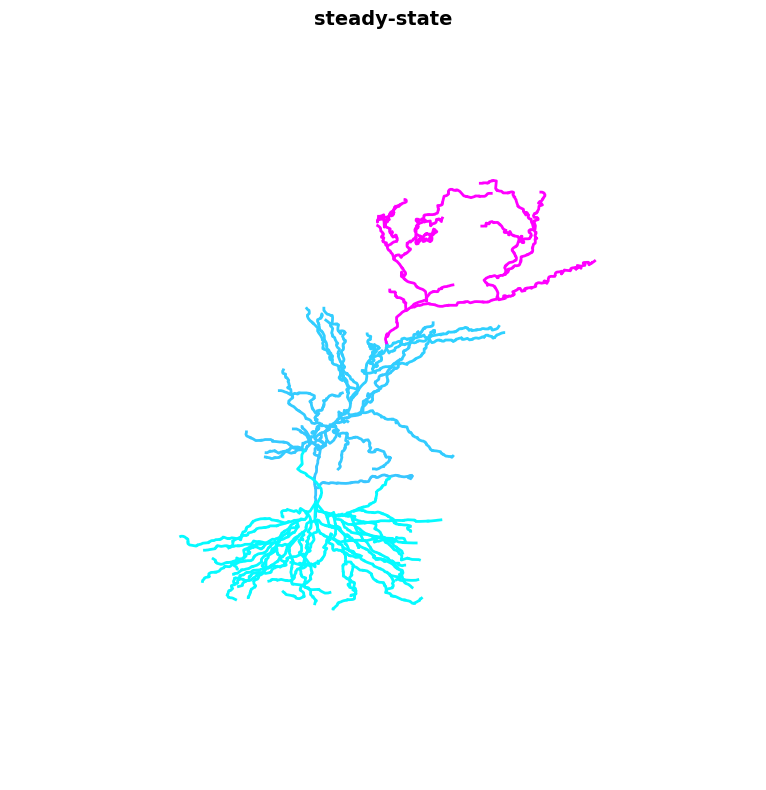

In [34]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=0)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('1b')

# animation
#animate_sim()

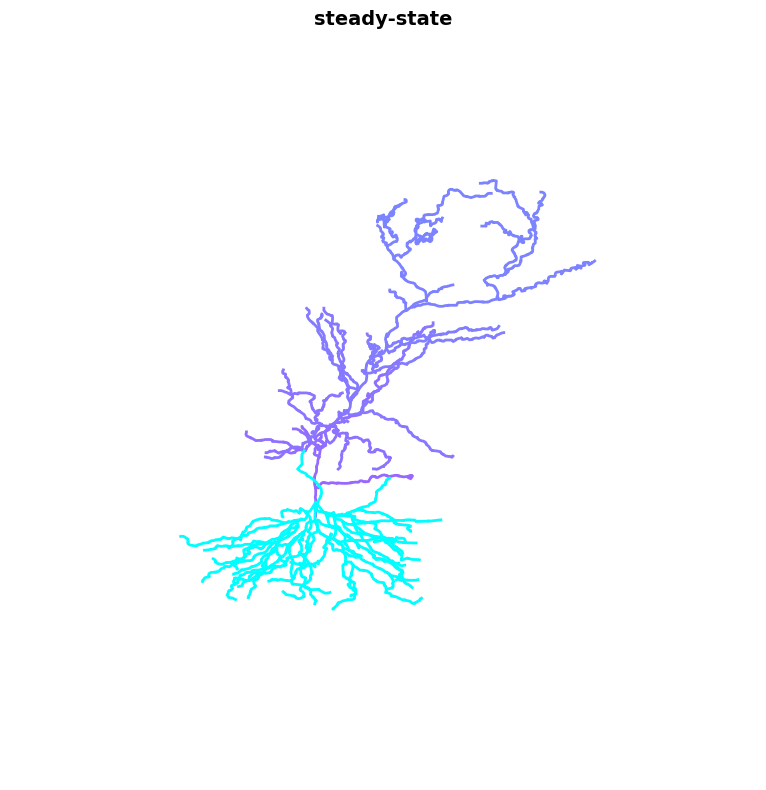

In [33]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('1b')

# animation
#animate_sim()

Second Case: timescales not separated, proximal inputs are *greedy* and prevent distal transport
----

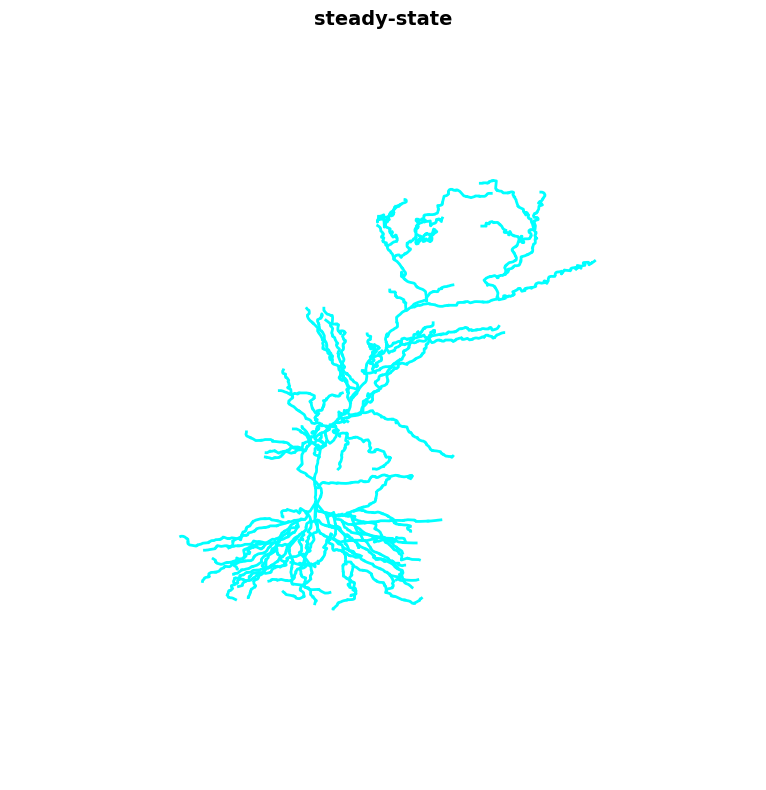

In [13]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('2a')

# animation
#animate_sim()

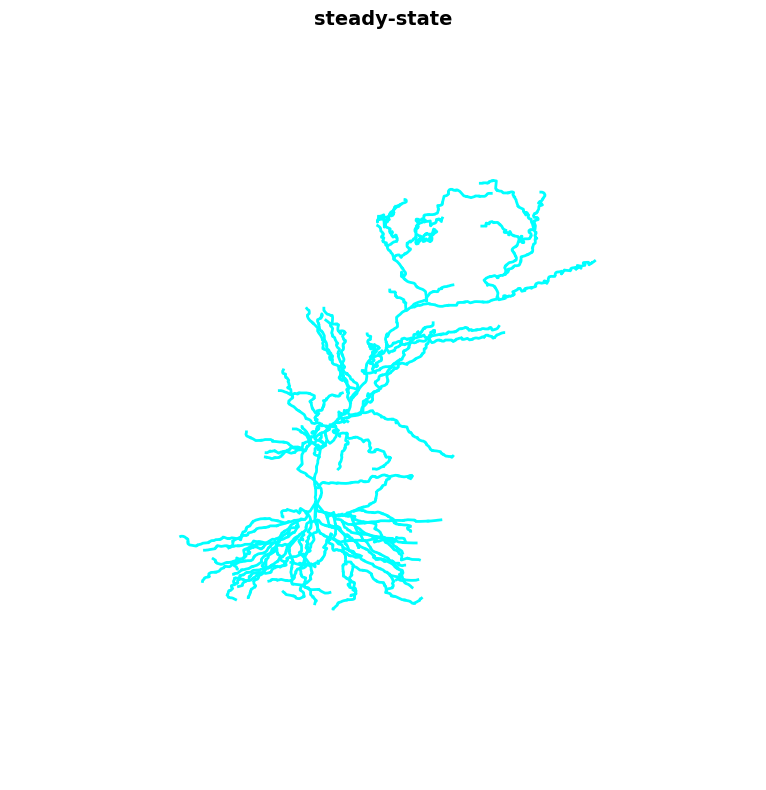

In [14]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=1,Ctau=1e-4)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('2b')

# animation
#animate_sim()

Third Case: Time scales separated, different trafficking strategy
------

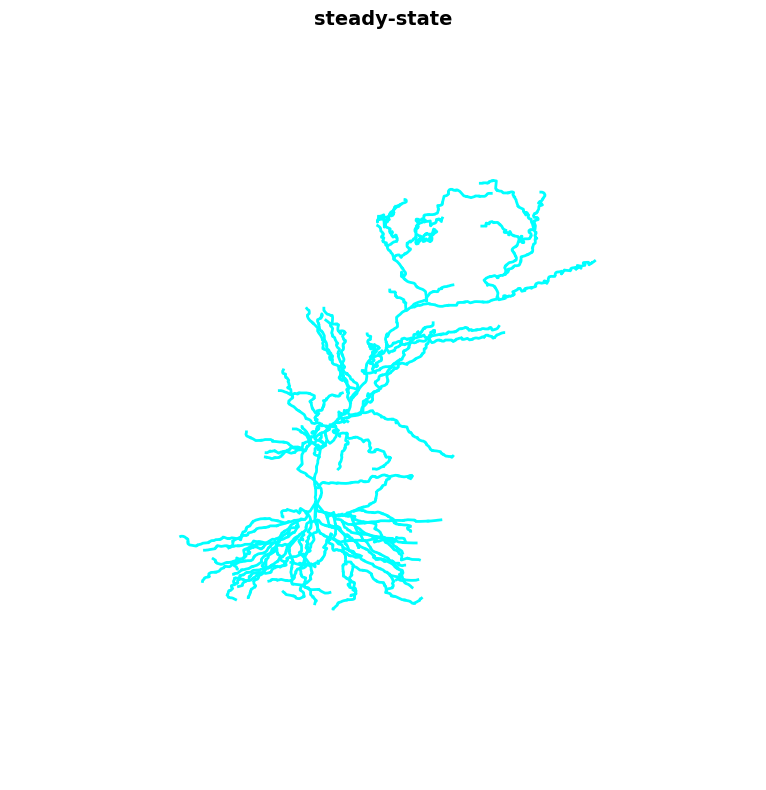

In [15]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=2e-4)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('3a')

# animation
#animate_sim()

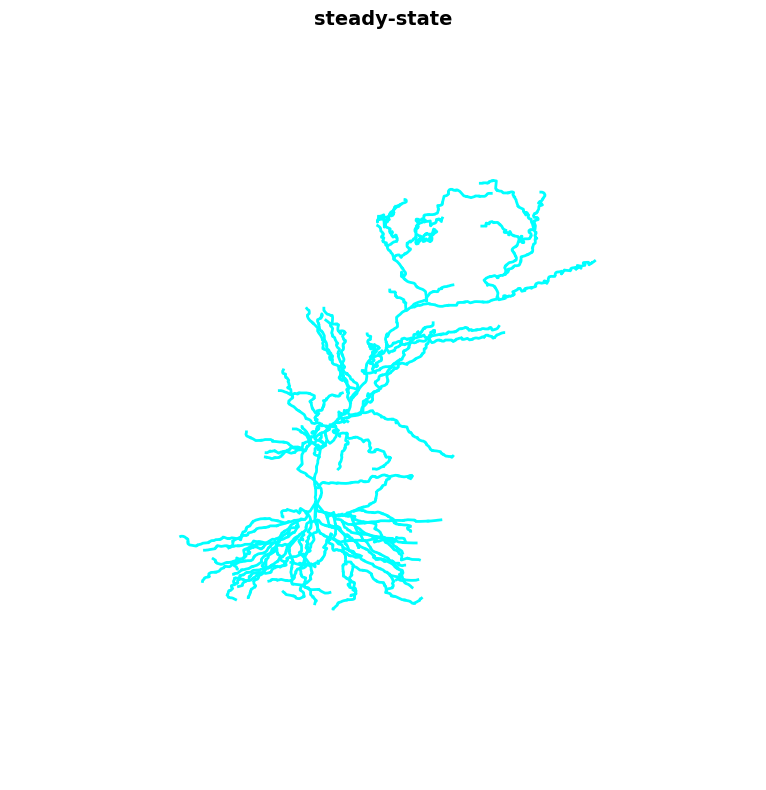

In [16]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 0.1 # no proximal trafficking
utarg /= np.sum(utarg)

# Run simulation
A = get_sys_matrix(utarg,F=0,Ctau=5e-4)
utrace = run_sim(A)

# snapshot of steady-state
snap_ss('3b')

# animation
#animate_sim()

In [18]:
utrace.shape

(1484, 11)

In [22]:
nframes=10
t = np.logspace(-0.5,8.5,nframes)
t.shape

(10,)

In [28]:
cvals=utrace[:,-1]
cvals.shape

(1484,)

In [29]:
1484/len(seg_list)

2.0

In [30]:
t

array([3.16227766e-01, 3.16227766e+00, 3.16227766e+01, 3.16227766e+02,
       3.16227766e+03, 3.16227766e+04, 3.16227766e+05, 3.16227766e+06,
       3.16227766e+07, 3.16227766e+08])